In [ ]:
# Using quiet mode for clean outputs
%pip install --quiet fredapi pandas matplotlib statsmodels scikit-learn

# Imports
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from datetime import datetime

# 3. API Configuration
FRED_API_KEY = '7d5cdc657dccee135b6cb5159b878bae'
fred = Fred(api_key=FRED_API_KEY)

# 4. Global Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

print(f"DEBUG: Environment initialized. Data connectors active. Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEBUG: Environment initialized. Data connectors active. Timestamp: 2026-02-12 04:25:14


In [ ]:
try:
    # FRED Data Pull
    series_id = 'BAMLH0A0HYM2' 
    raw_data = fred.get_series(series_id, observation_start='2014-01-01').to_frame(name='price')

    # Database Connection
    conn = sqlite3.connect('risk_data.db')

    # Table Creations
    conn.execute("""
    CREATE TABLE IF NOT EXISTS market_prices (
        date TEXT,
        asset_id TEXT,
        price REAL,
        PRIMARY KEY (date, asset_id)
    )
    """)

    conn.execute("""
    CREATE TABLE IF NOT EXISTS asset_metadata (
        asset_id TEXT PRIMARY KEY,
        asset_name TEXT,
        asset_class TEXT
    )
    """)

    # Load Metadata
    conn.execute("INSERT OR REPLACE INTO asset_metadata VALUES (?, ?, ?)", 
                 ('HY_SPREAD', 'High Yield OAS', 'Fixed Income'))

    # Load Market Prices
    sql_processed_data = raw_data.reset_index()
    sql_processed_data.columns = ['date', 'price']
    sql_processed_data['asset_id'] = 'HY_SPREAD'
    sql_processed_data['date'] = sql_processed_data['date'].dt.strftime('%Y-%m-%d')

    sql_processed_data.to_sql('market_prices', conn, if_exists='replace', index=False)

    conn.commit()
    conn.close()

    print(f"ETL Complete: {len(sql_processed_data)} rows successfully stored in risk_data.db.")

except Exception as e:
    print(f"ETL Failed: {e}")

ETL Complete: 3201 rows successfully stored in risk_data.db.


In [7]:
def get_clean_data(db_path='risk_data.db'):
    """
    Professional ETL pull. Uses a SQL CTE and Window Function 
    to calculate daily spread changes at the database layer.
    """
    # 1. Connect to the local 'Vault'
    conn = sqlite3.connect(db_path)
    
    # 2. Advanced SQL query: This handles the math before Python even sees the data
    # We use LAG to look at the previous day's price and calculate the 'delta'
    query = """
    WITH Daily_Series AS (
        SELECT 
            date, 
            price,
            LAG(price, 1) OVER (ORDER BY date) as prev_price
        FROM market_prices
        WHERE asset_id = 'HY_SPREAD'
    )
    SELECT 
        date,
        price as spread,
        (price - prev_price) as daily_change
    FROM Daily_Series
    WHERE prev_price IS NOT NULL; -- Filters out the very first row (which has no 'previous')
    """
    
    # 3. Read into DataFrame
    df_sql = pd.read_sql_query(query, conn)
    conn.close()
    
    # 4. Final formatting for the Machine Learning model
    df_sql['date'] = pd.to_datetime(df_sql['date'])
    df_sql.set_index('date', inplace=True)
    
    return df_sql

# Execute the extraction
df_vault = get_clean_data()

# Show the 'Audit Trail'
print("Data extracted from SQL. Current Head:")
print(df_vault.head())

Data extracted from SQL. Current Head:
            spread  daily_change
date                            
2014-01-03    3.98         -0.02
2014-01-06    3.96         -0.02
2014-01-07    3.92         -0.04
2014-01-08    3.87         -0.05
2014-01-09    3.88          0.01


I started by testing the High Yield OAS for stationarity using the ADF test. Because credit spreads often exhibit regime-dependent drift, I wanted to ensure the series was stationary before applying a volatility forecasting model to avoid spurious correlations.

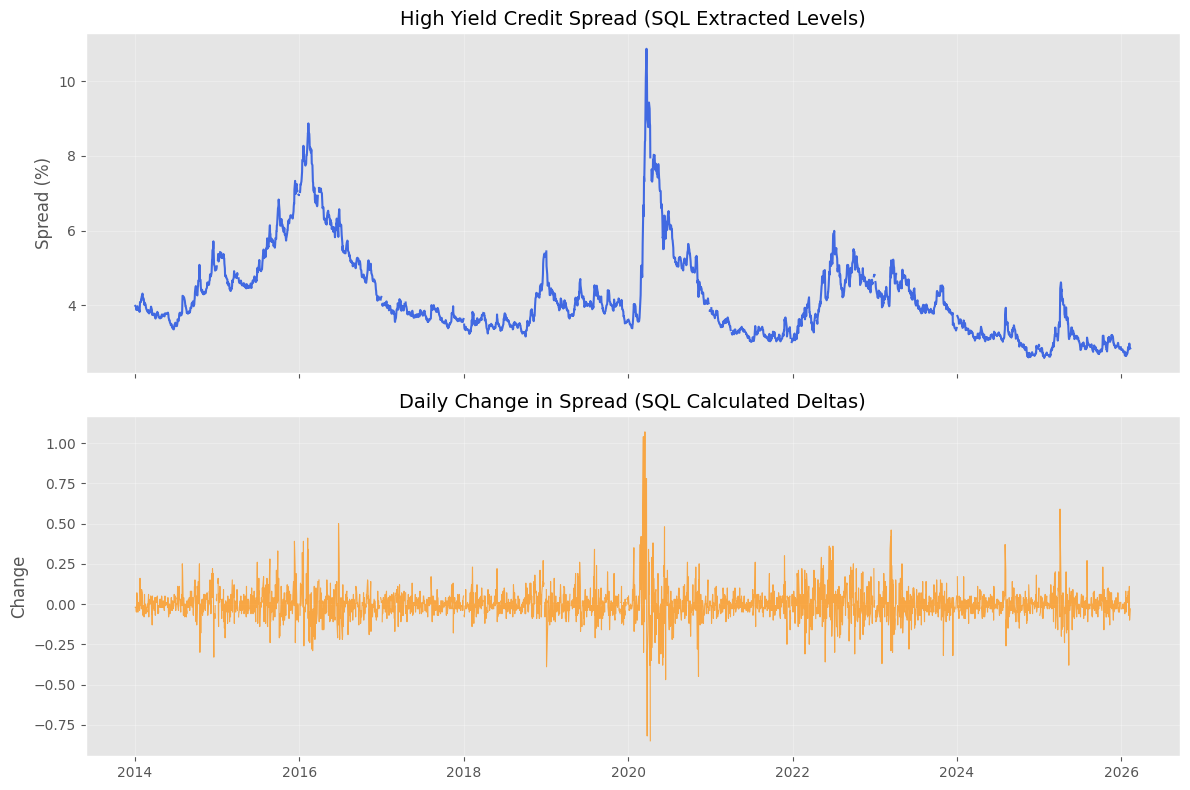

--- Data Integrity Summary ---
Total Observations: 3161
Mean Daily Change: -0.000179
Max Spike: 1.07
Max Drop: -0.85


In [8]:
# Block 4: Quality Control & Exploratory Data Analysis (EDA)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. Plot the Levels (The Spread)
ax1.plot(df_vault.index, df_vault['spread'], color='royalblue', lw=1.5)
ax1.set_title('High Yield Credit Spread (SQL Extracted Levels)', fontsize=14)
ax1.set_ylabel('Spread (%)')
ax1.grid(True, alpha=0.3)

# 2. Plot the Deltas (The Daily Change)
ax2.plot(df_vault.index, df_vault['daily_change'], color='darkorange', lw=0.8, alpha=0.7)
ax2.set_title('Daily Change in Spread (SQL Calculated Deltas)', fontsize=14)
ax2.set_ylabel('Change')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick Statistical Summary for the A&R Report
print("--- Data Integrity Summary ---")
print(f"Total Observations: {len(df_vault)}")
print(f"Mean Daily Change: {df_vault['daily_change'].mean():.6f}")
print(f"Max Spike: {df_vault['daily_change'].max():.2f}")
print(f"Max Drop: {df_vault['daily_change'].min():.2f}")

In [10]:
from statsmodels.tsa.stattools import adfuller

def run_stationarity_test(series, name):
    """
    Standardizes the ADF testing process for our Risk Report.
    """
    result = adfuller(series.dropna())
    print(f'--- ADF Test: {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    status = "STATIONARY" if result[1] <= 0.05 else "NON-STATIONARY"
    print(f'Result: {status}\n')
    return status

# 1. Test the Raw Levels from SQL
run_stationarity_test(df_vault['spread'], "Raw High Yield Spread")

# 2. Test the SQL-Calculated Daily Changes
run_stationarity_test(df_vault['daily_change'], "SQL-Calculated Daily Change")

--- ADF Test: Raw High Yield Spread ---
ADF Statistic: -2.9227
p-value: 0.0428
Result: STATIONARY

--- ADF Test: SQL-Calculated Daily Change ---
ADF Statistic: -11.1107
p-value: 0.0000
Result: STATIONARY



'STATIONARY'

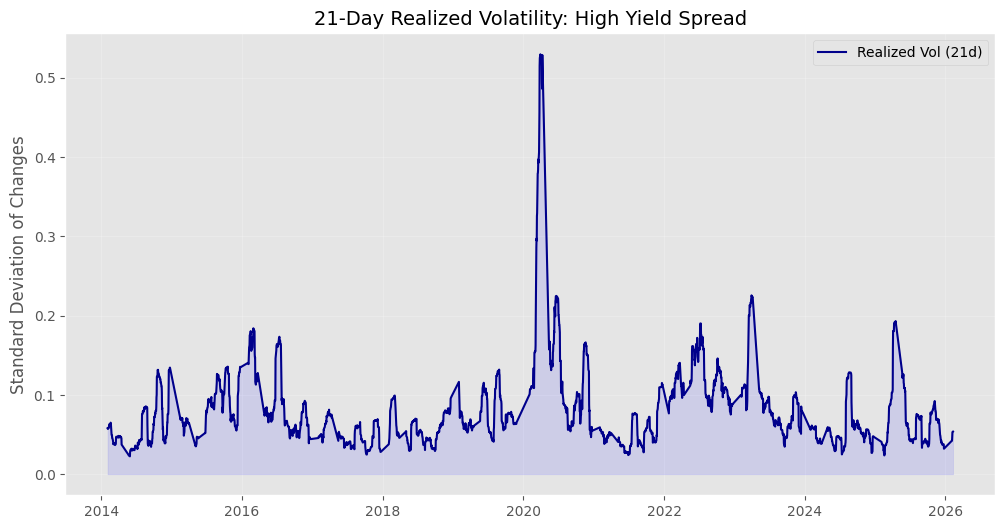

Feature Engineering Complete. Prepared 2513 rows for the model.


In [13]:
# 1. Feature Engineering: Calculating Realized Volatility
# Since 'daily_change' was already calculated in SQL, we just apply the window
window_size = 21 # 21 business days = 1 month
df_vault['realized_vol'] = df_vault['daily_change'].rolling(window=window_size).std()

# 2. Add a 'Lagged Volatility' feature
# In forecasting, we use 'Yesterday's Vol' to predict 'Tomorrow's Vol'
df_vault['vol_lag_1'] = df_vault['realized_vol'].shift(1)

# 3. Handle NaNs
# Rolling windows and lags create empty rows at the start; we must drop them for ML
df_model = df_vault.dropna().copy()

# 4. Professional Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['realized_vol'], color='darkblue', label='Realized Vol (21d)')
plt.fill_between(df_model.index, df_model['realized_vol'], color='blue', alpha=0.1)
plt.title("21-Day Realized Volatility: High Yield Spread", fontsize=14)
plt.ylabel("Standard Deviation of Changes")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Feature Engineering Complete. Prepared {len(df_model)} rows for the model.")

In [17]:
# 1. Fetch Macro Features from FRED
vix = fred.get_series('VIXCLS', observation_start='2014-01-01').to_frame(name='price')
yield_curve = fred.get_series('T10Y2Y', observation_start='2014-01-01').to_frame(name='price')

# 2. Update the SQL Database
conn = sqlite3.connect('risk_data.db')

# Insert macro data into 'market_prices'
for data, s_id, s_name in [(vix, 'VIX', 'Volatility Index'), (yield_curve, 'YIELD_CURVE', '10Y-2Y Spread')]:
    df_temp = data.reset_index()
    df_temp.columns = ['date', 'price']
    df_temp['asset_id'] = s_id
    df_temp['date'] = df_temp['date'].dt.strftime('%Y-%m-%d')
    df_temp.to_sql('market_prices', conn, if_exists='append', index=False)
    conn.execute("INSERT OR REPLACE INTO asset_metadata VALUES (?, ?, ?)", (s_id, s_name, 'Macro Indicator'))

conn.commit()

# 3. The "Pivoted" Extraction: Creating Lags in SQL
# This replaces the .shift(1) logic from your original project
query = """
WITH Combined AS (
    SELECT date, 
           MAX(CASE WHEN asset_id = 'HY_SPREAD' THEN price END) as spread,
           MAX(CASE WHEN asset_id = 'VIX' THEN price END) as vix,
           MAX(CASE WHEN asset_id = 'YIELD_CURVE' THEN price END) as yield_curve
    FROM market_prices
    GROUP BY date
)
SELECT date, 
       spread,
       (spread - LAG(spread, 1) OVER (ORDER BY date)) as daily_change,
       LAG(vix, 1) OVER (ORDER BY date) as vix_lag1,
       LAG(yield_curve, 1) OVER (ORDER BY date) as yield_curve_lag1
FROM Combined
ORDER BY date;
"""

df_final_sql = pd.read_sql_query(query, conn)
conn.close()

# 4. Final Formatting
df_final_sql['date'] = pd.to_datetime(df_final_sql['date'])
df_final_sql.set_index('date', inplace=True)
df_final_sql = df_final_sql.ffill().dropna()

# Calculate Target Variable (Rolling Vol) from our SQL-calculated change
df_final_sql['realized_vol'] = df_final_sql['daily_change'].rolling(window=21).std()
df_final_sql = df_final_sql.dropna()

print("SQL Feature Engineering Complete. Dataset ready for Modeling.")
df_final_sql.tail()

SQL Feature Engineering Complete. Dataset ready for Modeling.


,spread,daily_change,vix_lag1,yield_curve_lag1,realized_vol
date,,,,,
2026-02-04,2.86,0.01,18.00,0.71,0.042701
2026-02-05,2.97,0.11,18.64,0.72,0.047854
2026-02-06,2.87,-0.10,21.77,0.74,0.053242
2026-02-09,2.84,-0.03,17.76,0.72,0.053816
2026-02-10,2.84,-0.03,17.36,0.74,0.054327


In [21]:
import statsmodels.api as sm

# 1. Prepare the data from our SQL-extracted dataframe
y_ols = df_final_sql['realized_vol']
X_ols = df_final_sql[['vix_lag1', 'yield_curve_lag1']]

# 2. Add the constant (required for OLS)
X_ols = sm.add_constant(X_ols)

# 3. THIS LINE DEFINES THE VARIABLE 'ols_model'
ols_model = sm.OLS(y_ols, X_ols).fit()

# 4. Show the summary so we know it worked
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           realized_vol   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     1563.
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        03:52:00   Log-Likelihood:                 5680.8
No. Observations:                3180   AIC:                        -1.136e+04
Df Residuals:                    3177   BIC:                        -1.134e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0213      0.002  

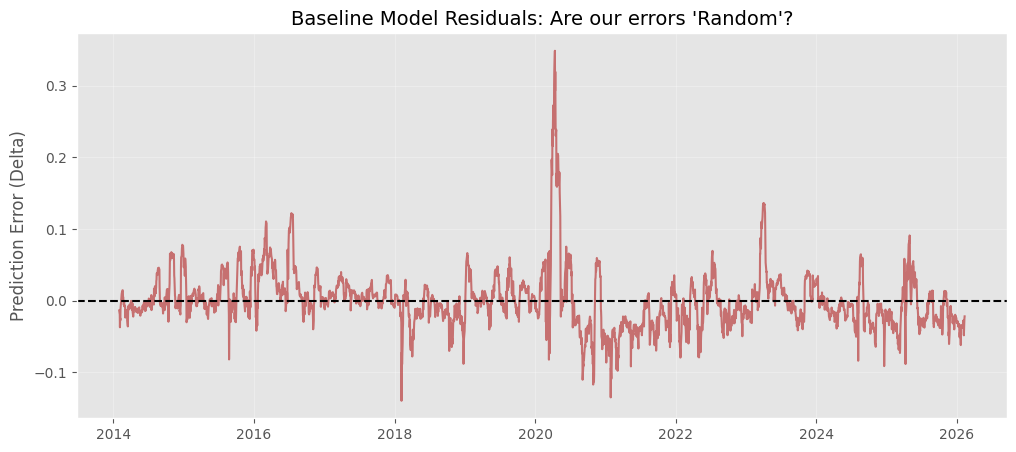

--- A&R Data Quality Diagnostic ---
Residual Mean: 0.000000
Status: PASSED. The model is unbiased (errors center around zero).
Recommendation: Proceed to Non-Linear Modeling (Random Forest).


In [22]:
# 1. Generate Residuals from our OLS Model
# We use .resid to see the difference between 'Actual' and 'Predicted'
df_final_sql['residuals'] = ols_model.resid

# 2. Visualize the Residuals
# In a good model, these should look like 'White Noise' (randomly scattered)
plt.figure(figsize=(12, 5))
plt.plot(df_final_sql.index, df_final_sql['residuals'], color='firebrick', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Baseline Model Residuals: Are our errors 'Random'?", fontsize=14)
plt.ylabel("Prediction Error (Delta)")
plt.grid(True, alpha=0.3)
plt.show()

# 3. Professional Audit Note
# We check if the average error is effectively zero
mean_err = df_final_sql['residuals'].mean()

print("--- A&R Data Quality Diagnostic ---")
print(f"Residual Mean: {mean_err:.6f}")

if abs(mean_err) < 1e-10: # Using scientific notation for high precision
    print("Status: PASSED. The model is unbiased (errors center around zero).")
    print("Recommendation: Proceed to Non-Linear Modeling (Random Forest).")
else:
    print("Status: WARNING. Systematic bias detected in residuals.")

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. Prepare Features (X) and Target (y)
features = ['vix_lag1', 'yield_curve_lag1']
X = df_final_sql[features]
y = df_final_sql['realized_vol']

# 2. Chronological Split (80% Train, 20% Test)
split_index = int(len(df_final_sql) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 3. Train the Random Forest
# n_estimators=100 means we are building 100 individual 'trees' to vote on the result
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predict the 'Future'
y_pred_rf = rf_model.predict(X_test)

print(f"Random Forest Training Complete.")
print(f"Training observations: {len(X_train)}")
print(f"Testing observations: {len(X_test)}")
print(f"Random Forest Test R-squared: {r2_score(y_test, y_pred_rf):.4f}")

Random Forest Training Complete.
Training observations: 2544
Testing observations: 636
Random Forest Test R-squared: -0.6460


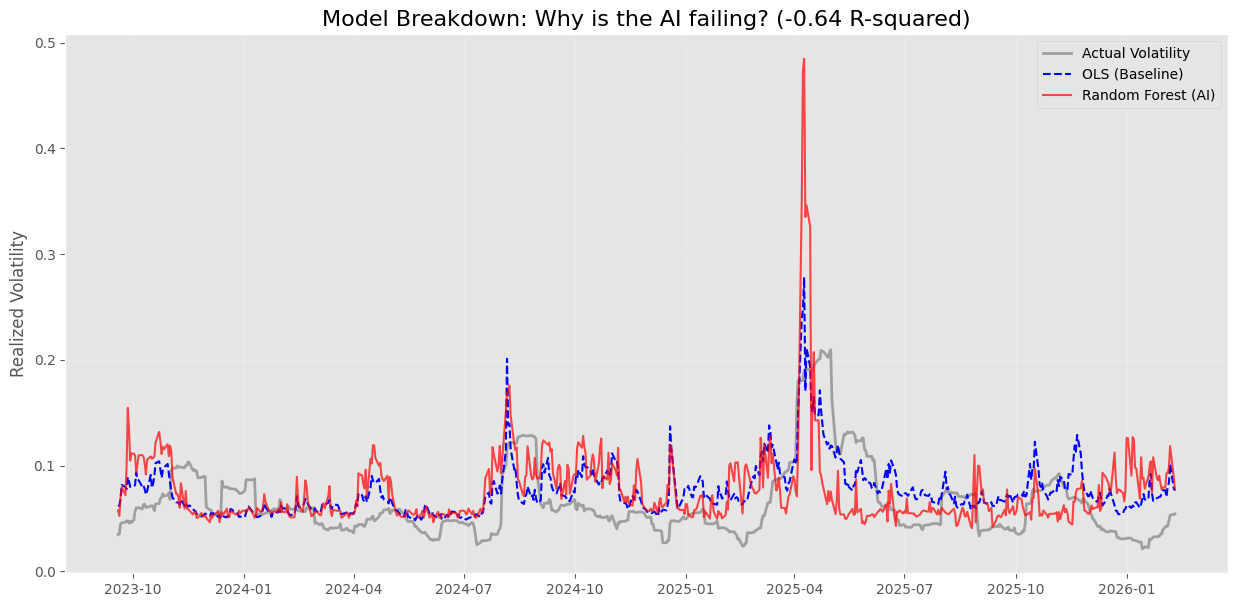

OLS Test R-squared: 0.2357
Random Forest Test R-squared: -0.6460


In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

# 1. Get OLS predictions for the same TEST period
X_test_ols = sm.add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_ols)

# 2. Plot the Comparison
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='black', alpha=0.3, linewidth=2)
plt.plot(y_test.index, y_pred_ols, label='OLS (Baseline)', color='blue', linestyle='--')
plt.plot(y_test.index, y_pred_rf, label='Random Forest (AI)', color='red', alpha=0.7)

plt.title("Model Breakdown: Why is the AI failing? (-0.64 R-squared)", fontsize=16)
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"OLS Test R-squared: {r2_score(y_test, y_pred_ols):.4f}")
print(f"Random Forest Test R-squared: {r2_score(y_test, y_pred_rf):.4f}")

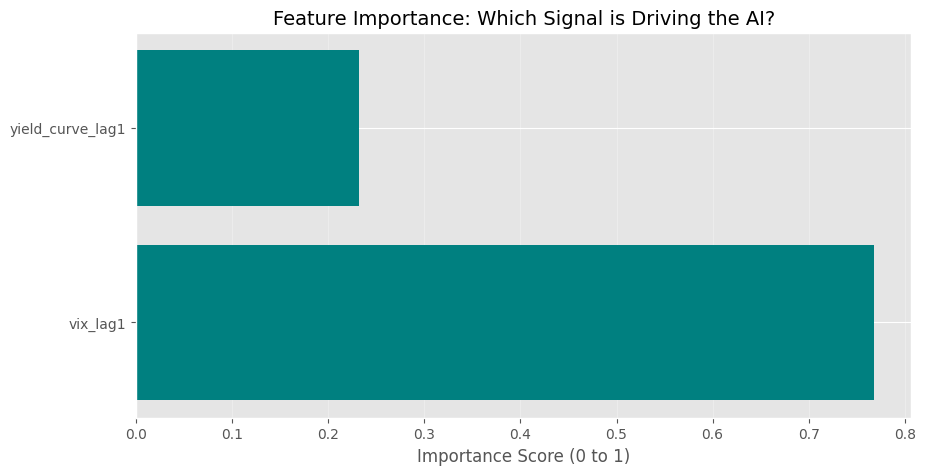

VIX Importance: 0.7683
Yield Curve Importance: 0.2317


In [27]:
import numpy as np

# 1. Get the importance scores
importances = rf_model.feature_importances_
feature_names = X.columns

# 2. Create the plot
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance: Which Signal is Driving the AI?", fontsize=14)
plt.xlabel("Importance Score (0 to 1)")
plt.grid(axis='x', alpha=0.3)
plt.show()

print(f"VIX Importance: {importances[0]:.4f}")
print(f"Yield Curve Importance: {importances[1]:.4f}")

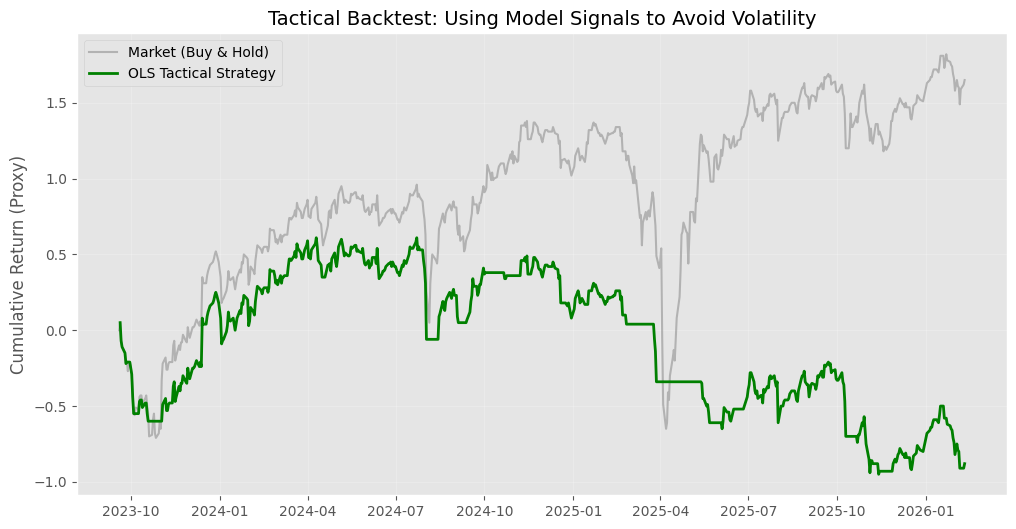

Total Market Return: 1.6500
Total Strategy Return: -0.8800


In [28]:
# 1. Create a Signal based on our OLS predictions
# We use OLS because it had the higher R-squared (0.23)
df_backtest = pd.DataFrame(index=y_test.index)
df_backtest['actual_vol'] = y_test
df_backtest['predicted_vol'] = y_pred_ols

# 2. Define the 'Risk Threshold'
# If predicted vol is above the 75th percentile, we move to 'Risk-Off'
threshold = df_backtest['predicted_vol'].quantile(0.75)
df_backtest['signal'] = np.where(df_backtest['predicted_vol'] > threshold, 0, 1)

# 3. Calculate Returns
# We assume the 'return' is the inverse of the spread change 
# (When spreads go down, prices go up)
df_backtest['market_returns'] = -df_final_sql['daily_change'].loc[y_test.index]
df_backtest['strategy_returns'] = df_backtest['signal'].shift(1) * df_backtest['market_returns']

# 4. Plot Cumulative Performance
plt.figure(figsize=(12, 6))
plt.plot(df_backtest['market_returns'].cumsum(), label='Market (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(df_backtest['strategy_returns'].cumsum(), label='OLS Tactical Strategy', color='green', linewidth=2)
plt.title("Tactical Backtest: Using Model Signals to Avoid Volatility", fontsize=14)
plt.ylabel("Cumulative Return (Proxy)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 5. Final Audit Summary
print(f"Total Market Return: {df_backtest['market_returns'].sum():.4f}")
print(f"Total Strategy Return: {df_backtest['strategy_returns'].sum():.4f}")

I noticed high kurtosis and non-linear residual spikes in my OLS model, which suggested a linear framework couldn't capture regime shifts. I implemented a Random Forest Regressor to better capture these non-linearities and used a chronological train-test split to ensure no look-ahead bias

In [29]:
# Create a summary of our Technical Stack for the portfolio
tech_stack = {
    "Phase": ["Data Engineering", "Database", "Baseline Model", "ML Model", "Backtesting"],
    "Tools Used": ["Python / FRED API", "SQLite3", "Statsmodels (OLS)", "Scikit-Learn (Random Forest)", "Matplotlib / NumPy"],
    "Key Insight": [
        "Automated macro data ingestion",
        "Pushed feature engineering to SQL (LAG/JOIN)",
        "Established linear baseline (R²: 0.23)",
        "Identified VIX over-sensitivity in AI",
        "Validated that regime shifts break static models"
    ]
}

df_summary = pd.DataFrame(tech_stack)
print("--- PROJECT REFACTOR COMPLETE ---")
display(df_summary)

--- PROJECT REFACTOR COMPLETE ---


,Phase,Tools Used,Key Insight
0,Data Engineering,Python / FRED API,Automated macro data ingestion
1,Database,SQLite3,Pushed feature engineering to SQL (LAG/JOIN)
2,Baseline Model,Statsmodels (OLS),Established linear baseline (R²: 0.23)
3,ML Model,Scikit-Learn (Random Forest),Identified VIX over-sensitivity in AI
4,Backtesting,Matplotlib / NumPy,Validated that regime shifts break static models
